Reinforcement Learning for the Tower of Hanoi
========================

Introduction
-------------

The purpose of this notebook is to be a self-contained explanation of the RL algorithms used in [my GitHub repo](https://github.com/RojerGS/AIML/tree/master/HanoiRL) where I try to solve the Tower of Hanoi.

I will try to be as clear as possible in everything I do, as I will also be taking parts of this notebook (as I write them) and publish them in my [maths and programming blog](https://mathspp.blogspot.com).

Contents of this notebook
---------------------------
 * [The problem](#theproblem)
   - [Encoding the Tower of Hanoi as a markov decision process](#encoding)
   - [Visualizing a game session](#visualization)
 * [Value iteration](#value_iteration)
 * [Policy iteration](#policy_iteration)
 * [Q-learning](#q_learning)
   - [Double Q-learning](#doubleq_learning)

<a id="theproblem"></a>
The problem
------------

The Tower of Hanoi is a puzzle in the form of a simple toy:

![A Tower of Hanoi toy](https://4.bp.blogspot.com/-RQ2qBzhT4uQ/W7OoofQs0QI/AAAAAAAABDc/Dw5qg_55sGYXEFZ9bIzhUj6TMtVipAvSQCLcBGAs/s1600/frame08.png "Tower of Hanoi")

composed of three poles and a set of different-sized disks (4 in the image above). The disks start all in the left pole, with the biggest disk on the bottom, all the way up to the smallest disk on top. The goal of the puzzle is to move *all* disks to a different pole than the starting one by moving one disk at a time. There is only one simple restriction: a disk can never be on top of a smaller disk!

<a id="encoding"></a>
### Encoding the Tower of Hanoi as a markov decision process

The first thing to do is to encode the puzzle of the Tower of Hanoi as a markov decision process. Recall that an [mdp](https://mathspp.blogspot.com/2018/09/markov-decision-processes-basics.html) needs five ingredients to be well-defined, a quintuple $(S, A, P_a, R_a, \gamma)$ with the states, the actions, the transition probabilities, the rewards and the discount factor $\gamma$. The discount factor will be left undefined for now and we will fiddle with it when we implement the different algorithms.

For this explanation assume the number of disks $N$ is fixed. We will define $3^N + 1$ states: $3^N$ are all the ways in which the disks can be distributed legally among the three poles. The $+1$ is for the terminal state we want to reach when the algorithm thinks the puzzle has been completed.

For the regular game states we will use a list of three lists, where each sublist will have the numbers corresponding to the disks in that pole; for example, the list

```
[
[],
[3,2,1],
[4]
]
```

corresponds to the setting of the above image. Notice that bigger numbers correspond to bigger disks and that the bottom of the pole corresponds to the beginning of the list, hence the list above can be further identified with the image above if we rotate the image $90^\circ$ clockwise; the terminal state will be represented by a constanst.

We can thus define the following `define_states` function:

In [3]:
FINAL_STATE = "DONE"    # special state for when the Hanoi Tower was solved

def define_states(n):
    """Recursively define all the possible states of an n-disk Hanoi tower"""
    def aux(n):
        if n == 1:
            return [
                    [[1],[],[]],
                    [[],[1],[]],
                    [[],[],[1]]
                    ]
        else:
            partial = aux(n-1)
            final = []
            for state in partial:
                a, b, c = state
                final.append([[n]+a, b, c])
                final.append([a, [n]+b, c])
                final.append([a, b, [n]+c])
            return final

    return [FINAL_STATE] + aux(n)

After defining the states we now define the actions. We will define $7$ actions: $6$ of them will be the states corresponding to moving disks from one of the poles to any of the other two poles; those will be written as 2-character strings. The first character of the string represents the pole from which we removed and the second character represents the pole in which we want to insert.

The seventh action is for when the algorithm thinks it has completed the puzzle and hence "claims" the puzzle has been finished. For this action we use another constant.

In [4]:
COMPLETED = "COMPLETED" # special action when the MDP thinks we are done
actions = [COMPLETED, "LC", "LR", "CL", "CR", "RL", "RC"]

After having defined states and actions we are now in position to define transition probabilities and rewards. We will assume all actions are available in all game states (_except_ for the terminal state where no action is available) but the restrictions imposed by the rules will be reflected in the transitions.

Whenever a move is illegal (goes against the rules), whenever the move tries to remove a disk from an empty pole or the algorithm claims the puzzle is complete but isn't, we incurr in a penalty and we transition to the exact same state.

Whenever the action represents a move and is legal, the state transition occurs as per the puzzle rules and there is no reward (i.e. the reward is $0$).

Whenever we claim the puzzle is complete from one of the two final positions and thus enter the terminal state, we get a positive reward.

This information is all encoded in the function `transition` which also makes use of the helper function `game_is_done`, used to check if the puzzle has indeed been done.

In [6]:
from copy import deepcopy

def game_is_done(state):
    """Return if the Hanoi Tower was solved;
        Assume we always start with all disks on the left"""
    return (len(state[0]) == len(state[1]) == 0 and \
                sorted(state[2], reverse=True) == state[2]) or \
            (len(state[0]) == len(state[2]) == 0 and \
                sorted(state[1], reverse=True) == state[1])

def transition(state, action):
    """Given a <state> and an <action>, return the new state
        and the reward we got.
    The actions are of the form L|C|R + L|C|R,
        where the first character says from where we remove (Left,Centre,Right)
        the second character says where we are inserting (Left,Centre,Right)
        OR
        COMPLETED to transition into the final state when the game is done"""
    R_illegal = -3      # reward if the action was an illegal move
    R_final = 5         # reward if we end the game
    R_default = 0       # default reward

    # deal with the action COMPLETED separately
    if action == COMPLETED:
        if game_is_done(state):
            return FINAL_STATE, R_final
        else:
            return state, R_illegal

    state_ = deepcopy(state)
    # disassemble the state and the action
    d = {'L': 0, 'C': 1, 'R': 2}
    i = d[action[0]]    # remove from this pile
    j = d[action[1]]    # insert into this pile
    if not state_[i]:   # can we remove?
        return state, R_illegal
    moving = state_[i].pop()
    if (state_[j] and moving > state_[j][-1]):
        # illegal move found
        return state, R_illegal
    else:
        state_[j].append(moving)
        return state_, R_default

We also define an auxiliary function `dictify` that turns a game state into something that can be used as a dictionary key (because lists can't). I didn't know this would be useful from the start, but turns out that when we use the algorithms it kind of helps, so lets just take that out of the way.

In [7]:
def dictify(state):
    """Turns a state into a valid dict key"""
    if state == FINAL_STATE:
        return state
    else:
        return tuple([tuple(item) for item in state])

To sum up, we recursively defined all the states in `define_states(N)` and implemented a transition function `transition(state, action)` that handles the transitions and the rewards. We also implemented two helper functions, `game_is_done)state)` to recognize if a state corresponds to one where the game is done and `dictify(state)` that will come in handy when we deal with dictionaries. We also defined all the available actions.

Below I present all the code as I have it in my `hanoi_mdp.py` file, available [in my GitHub](https://github.com/RojerGS/AIML/tree/master/HanoiRL).

In [8]:
# contents of hanoi_mdp.py, available at https://github.com/RojerGS/AIML/tree/master/HanoiRL
from copy import deepcopy

COMPLETED = "COMPLETED" # special action when the MDP thinks we are done
FINAL_STATE = "DONE"    # special state for when the Hanoi Tower was solved
actions = [COMPLETED, "LC", "LR", "CL", "CR", "RL", "RC"]

def dictify(state):
    """Turns a state into a valid dict key"""
    if state == FINAL_STATE:
        return state
    else:
        return tuple([tuple(item) for item in state])

def define_states(n):
    """Recursively define all the possible states of an n-disk Hanoi tower"""
    def aux(n):
        if n == 1:
            return [
                    [[1],[],[]],
                    [[],[1],[]],
                    [[],[],[1]]
                    ]
        else:
            partial = aux(n-1)
            final = []
            for state in partial:
                a, b, c = state
                final.append([[n]+a, b, c])
                final.append([a, [n]+b, c])
                final.append([a, b, [n]+c])
            return final

    return [FINAL_STATE] + aux(n)

def game_is_done(state):
    """Return if the Hanoi Tower was solved;
        Assume we always start with all disks on the left"""
    return (len(state[0]) == len(state[1]) == 0 and \
                sorted(state[2], reverse=True) == state[2]) or \
            (len(state[0]) == len(state[2]) == 0 and \
                sorted(state[1], reverse=True) == state[1])

def transition(state, action):
    """Given a <state> and an <action>, return the new state
        and the reward we got.
    The actions are of the form L|C|R + L|C|R,
        where the first character says from where we remove (Left,Centre,Right)
        the second character says where we are inserting (Left,Centre,Right)
        OR
        COMPLETED to transition into the final state when the game is done"""
    R_illegal = -3      # reward if the action was an illegal move
    R_final = 5         # reward if we end the game
    R_default = 0       # default reward

    # deal with the action COMPLETED separately
    if action == COMPLETED:
        if game_is_done(state):
            return FINAL_STATE, R_final
        else:
            return state, R_illegal

    state_ = deepcopy(state)
    # disassemble the state and the action
    d = {'L': 0, 'C': 1, 'R': 2}
    i = d[action[0]]    # remove from this pile
    j = d[action[1]]    # insert into this pile
    if not state_[i]:   # can we remove?
        return state, R_illegal
    moving = state_[i].pop()
    if (state_[j] and moving > state_[j][-1]):
        # illegal move found
        return state, R_illegal
    else:
        state_[j].append(moving)
        return state_, R_default

### Visualizing a game session
<a id="visualization"></a>

The function `print_game_sequence` defined below gets as input a list with game states and prints a frame for each state, for us to visualize the game progression.

This function uses `matplotlib.pyplot` so make sure you have that installed to use this "feature".

In [1]:
import matplotlib.pyplot as mp

def print_game_sequence(game):
    """Given a Tower of Hanoi game sequence,
        print a sequence of images representing the game"""
    if not game:
        return
    
    default_colours = ["b","g","r","c","m","y"] # default colours
    N = sum(map(len, game[0]))
    if N <= len(default_colours):
        colours = default_colours[:N]
    else:
        colours = [[i/N]*3 for i in range(N)] # use a scale of grays
    
    values = [i for i in range(N,0,-1)]
    for frame in game:
        # start with 3 tiny bars to represent the poles
        xs = [2,4,6]
        hs = [N]*3
        ws = [0.1]*3
        cs = [[0]*3]*3
        for bar in frame:
            xs += [2*(1+frame.index(bar))]*len(bar)
            for idx in range(len(bar)-1,-1,-1):
                hs.append(idx+1)
                w = 0.2 + 1.6*(bar[idx]/N)
                ws.append(w)
                cs.append(colours[bar[idx]-1])
        # add three "bars" that together make the base
        xs += [2,4,6]
        hs += [0.1]*3
        ws += [2]*3
        cs += [[0.2, 0.8, 0.66]]*3
        mp.bar(xs, hs, ws, color = cs)
        mp.axis("off")
        mp.ylim(0, N)
        mp.show()

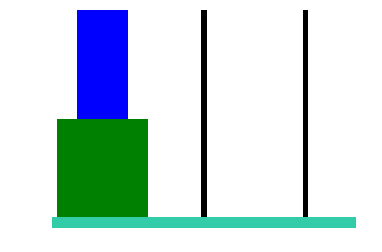

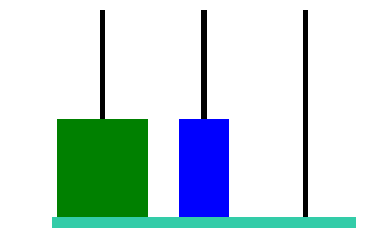

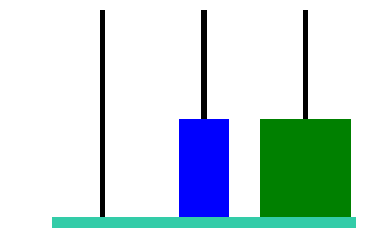

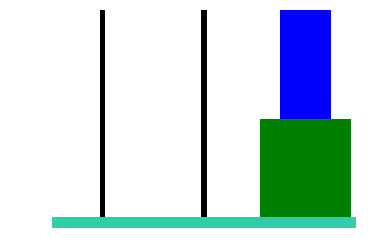

In [2]:
# example usage of print_game_sequence with a game of 2 disks played optimally
game = []
game.append([[2,1],[],[]])
game.append([[2],[1],[]])
game.append([[],[1],[2]])
game.append([[],[],[2,1]])
print_game_sequence(game)
del(game)

<a id="value_iteration"></a>
Value iteration
----------------

<a id="policy_iteration"></a>
Policy iteration
-----------------

<a id="q_learning"></a>
Q-learning
-----------

<a id="doubleq_learning"></a>
### Double Q-learning